## Preliminary Work & Data Overview

This file is about a sentiment classification task with dataset 'amarzon-polarity'. Main content of this file is about code that builds deep learning models with pytorch. We first install some modules. Note that to use the module 'gensim', you may have to downgrade numpy and scipy. After install the modules, you may have to **restart**. Otherwise, you may encounter ImportError.

In [ ]:
!pip install scipy==1.12.0
!pip install gensim==4.3.2
!pip install datasets

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!pip3 install transformers

In [ ]:
!pip install hf_xet

Import modules.

In [1]:
# import modules
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, RocCurveDisplay,roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from huggingface_hub import hf_hub_download
from transformers import BertTokenizer, BertModel
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from tqdm import tqdm
import pickle
import hf_xet

The module 'datasets' can load datasets from Hugging Face. Here we load the dataset 'amazon_polarity'. It contains a training and a test set.

In [3]:
# get the data
train = datasets.load_dataset('fancyzhx/amazon_polarity',split='train')
test  = datasets.load_dataset('fancyzhx/amazon_polarity',split='test')

In [4]:
X_train, y_train = train['content'], train['label']
X_test, y_test = test['content'], test['label']

We see the size of the sets.

In [6]:
len(y_train), len(y_test)

(3600000, 400000)

Due to the limitation of computing resource, we just use a subset of the whole dataset.  We randomly get 500,000 positive reviews and 500,000 negative reviews from the training data, and 100,000 reviews from the test set.

In [8]:
# get a subset of the whole data
train = pd.DataFrame({'X':X_train,'y':y_train})
test = pd.DataFrame({'X':X_test,'y':y_test})
train = pd.concat([train[train['y'] == 1].sample(n=500000,random_state=507),train[train['y'] == 0].sample(n=500000,random_state=507)])
test = test.sample(n=100000,random_state=507)
train.shape,test.shape

((1000000, 2), (100000, 2))

In [9]:
X_train, y_train = train['X'].values, train['y'].values
X_test, y_test = test['X'].values, test['y'].values

Print an example of the review.

In [12]:
print(X_train[0])

A big part of the book is mostly Egyption history. He talks about the dating of the pyrimids was a fraud, which is very interesting. He gets into the Enoch subject for a while and much more. A Daniken fan will love this book


We check the size of vocabulary for the train data.

In [15]:
# check the size of vocabulary for the train data
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
len(vectorizer.vocabulary_)

426803

We want to know how the length of the reviews in training set distributed. Below is the histogram of the lengths.

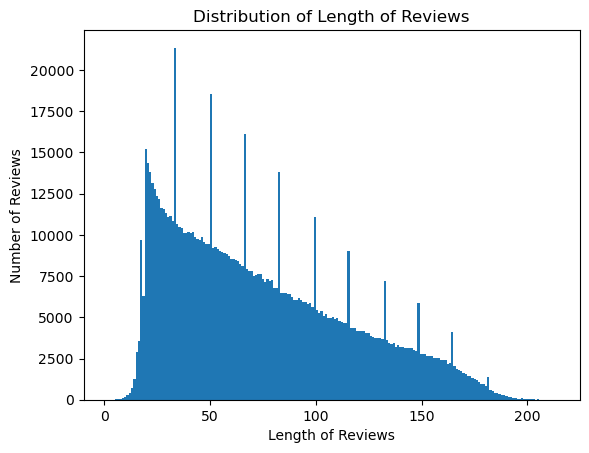

In [17]:
# get the distribution of the length of reviews in train data
review_lengths = [len(review.split(' ')) for review in X_train]
plt.hist(review_lengths,bins=200)
plt.xlabel('Length of Reviews')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Length of Reviews')
plt.show()

Some statistics about the length.

In [19]:
# some statistics about the length
pd.DataFrame(review_lengths).describe()

,0
count,1000000.000000
mean,74.109013
std,42.271075
min,1.000000
25%,39.000000
50%,66.000000
75%,103.000000
max,214.000000


For hyperperameter setting, we split the training set to a training and a validation set. The size ratio is 8:2.

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=507)

## Baseline model

Below, we implement our baseline model. It is built as a pipeline with the module 'sklearn'. First, it will transform reviews into TF-IDF features. This feature can evaluate how important a word is to a document within a collection (or corpus), while reducing the weight of common words that appear across many documents. Second, the features will be used to train a linear SVM classifier. After trying some groups of hyperparameters, we set hyperparameters as below.

For the TF-IDF vectorizer, we only consider the top 20,000 n-grams with the highest frequency, and we only consider 1-gram and 2-grams. For the linear SCV, we set C=0.1. These hyperparameter settings have been optimized during validation. Unless otherwise specified, the hyperparameter settings for the models below are all optimized during validation.

In [ ]:
# baseline model: TF-IDF feature and linear SVM classifier
model1 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000,ngram_range=(1,2))),
    ('svm', LinearSVC(C=0.1,dual=False))])

model1.fit(X_train,y_train)

Metrics of validation set.

In [35]:
# select the best hyperparameter setting using the validation set
pre_y_val1 = model1.predict(X_val)
print(classification_report(y_val,pre_y_val1))
print(accuracy_score(y_val,pre_y_val1))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91    100495
           1       0.91      0.91      0.91     99505

    accuracy                           0.91    200000
   macro avg       0.91      0.91      0.91    200000
weighted avg       0.91      0.91      0.91    200000

0.911675


Confusion matrix of validation set.

In [36]:
confusion_matrix(y_val,pre_y_val1)

array([[91583,  8912],
       [ 8753, 90752]], dtype=int64)

Use the trained model to predict test set.

In [38]:
pre_y_test1 = model1.predict(X_test)
print(classification_report(y_test,pre_y_test1))
print(accuracy_score(y_test,pre_y_test1))
print(f1_score(y_test,pre_y_test1))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     50299
           1       0.91      0.91      0.91     49701

    accuracy                           0.91    100000
   macro avg       0.91      0.91      0.91    100000
weighted avg       0.91      0.91      0.91    100000

0.91131
0.9109207235619657


In [39]:
confusion_matrix(y_test,pre_y_test1)

array([[45784,  4515],
       [ 4354, 45347]], dtype=int64)

Draw the ROC curve and compute the AUC.

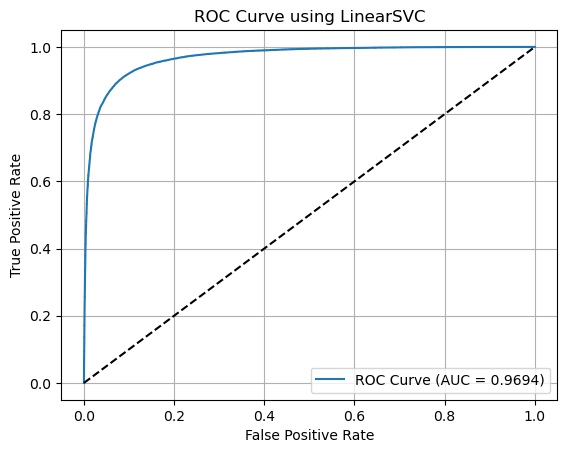

In [113]:
y_score1 = model1.decision_function(X_test)

fpr1, tpr1, _ = roc_curve(y_test, y_score1)
auc_score1 = roc_auc_score(y_test, y_score1)

plt.figure()
plt.plot(fpr1, tpr1, label=f'ROC Curve (AUC = {auc_score1:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve using LinearSVC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## GLoVe+LSTM

We now implement our deep learning model. The first model is a Glove+LSTM model. We first use a pre-trained and fine-tuned Glove model to transform words to vectors and then use word vectors to train a LSTM model. The pre-trained model is downloaded from Hugging Face. Then we will build a LSTM model with pytorch. This pre-trained model can convert a word to a 300-dimensional vector. The size of the vocabulary of the pre-trained model is 400,000.

In [65]:
# download the pre-trained model
model_path = hf_hub_download(repo_id="fse/glove-wiki-gigaword-300", filename="glove-wiki-gigaword-300.model")
vector_path = hf_hub_download(repo_id="fse/glove-wiki-gigaword-300", filename="glove-wiki-gigaword-300.model.vectors.npy")
pre_trained_model = KeyedVectors.load(model_path, mmap='r')

Construct the embedding matrix. If padding is needed, we use a zero vector to represent padding word. If there exists new word that is not in the pre-trained GloVe model, we use a randomly generated vector to represent it.

In [67]:
wordtoidx = {"<pad>": 0, "<unk>": 1}
vectors = [np.zeros(pre_trained_model.vector_size), np.random.normal(scale=0.6, size=pre_trained_model.vector_size)]

for word in pre_trained_model.key_to_index:
    wordtoidx[word] = len(wordtoidx)
    vectors.append(pre_trained_model[word])

embedding_matrix = torch.tensor(np.stack(vectors), dtype=torch.float)

In [47]:
embedding_matrix.shape

torch.Size([400002, 300])

We define a function that can encode the reviews. This function takes a review (str) as an input and outputs a list that contains the index of corresponding words in the review. What's more, this function applies padding or truncation to make sure that every review will has a fixed length. Here we set the length of any review should be no longer than 150.

In [68]:
def encode(text, max_len=150):
    tokens = simple_preprocess(text)
    ids = [wordtoidx.get(token, wordtoidx["<unk>"]) for token in tokens]
    return ids[:max_len] + [wordtoidx["<pad>"]] * (max_len - len(ids))


Construct torch Dataset and DataLoader.

In [72]:
class MyDataset(Dataset):
    def __init__(self, texts, labels):
        self.data = [torch.tensor(encode(text)) for text in texts]
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)
test_dataset = MyDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)


Define the LSTM model. This model first transforms text to word vectors based on the embedding matrix, then put the vectors into LSTM. This LSTM is a multi-layer and bidirectional one. Dropout technique is used to reduce overfitting. The LSTM output will go to a linear projection and a sigmoid activation. In the end, we will get results between 0 and 1.

Here, our LSTM is set to be a bidirectional one with two hidden layers. The dimension of the hidden layers is 512. We will apply dropout between hidden layers and in the last LSTM output. The dropout rate is 0.2.

In [73]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=512, num_layers=2, bidirectional=True,dropout_rate=0.2):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(
            input_size=embedding_matrix.size(1),
            hidden_size=hidden_dim,
            batch_first=True,
            num_layers = num_layers,
            bidirectional=bidirectional,
            dropout = dropout_rate

        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        last_hidden = lstm_out[:, -1, :]
        dropped = self.dropout(last_hidden)
        return self.sigmoid(self.fc(dropped))

The function below can conduct training process. 'max_epoch' controls the epoch of the training process. To avoid overfitting, we also apply early stop. That is, whenever there exists a validation loss increasing, we will stop at that epoch.

In [74]:
def training(model,train_loader,val_loader,optimizer,criterion,max_epoch=10,max_patience=1):
    if max_patience!=0:
      patience = 0
      min_val_loss = float('inf')
    for epoch in range(max_epoch):
        model.train()
        total_loss = 0
        for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x_batch, y_batch = x_batch.to(device), y_batch.unsqueeze(1).to(device)
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.unsqueeze(1).to(device)

                preds = model(x_val)
                loss = criterion(preds, y_val)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        if min_val_loss>avg_val_loss:
          min_val_loss = avg_val_loss
          patience = 0
        else:
          patience += 1
        print(f"Epoch {epoch+1} Avg Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        if patience == max_patience:
          print(f'Early stop at Epoch {epoch+1}')
          break
    return model

Training process. The optimizer is the commonly-used Adam with learning rate 1e-4. The loss criterion is the cross-entropy loss. To accelerate our training, we run the code on a NAVIDIA 4090 GPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(embedding_matrix,hidden_dim=512,num_layers=2,bidirectional=True,dropout_rate=0.2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

In [55]:
model = training(model,train_loader,val_loader,optimizer,criterion,max_epoch=10,max_patience=1)

Epoch 1: 100%|██████████| 3125/3125 [02:38<00:00, 19.73it/s]


Epoch 1 Avg Train Loss: 0.4990 | Val Loss: 0.2897


Epoch 2: 100%|██████████| 3125/3125 [02:38<00:00, 19.71it/s]


Epoch 2 Avg Train Loss: 0.2499 | Val Loss: 0.2289


Epoch 3: 100%|██████████| 3125/3125 [02:38<00:00, 19.71it/s]


Epoch 3 Avg Train Loss: 0.2064 | Val Loss: 0.2039


Epoch 4: 100%|██████████| 3125/3125 [02:38<00:00, 19.71it/s]


Epoch 4 Avg Train Loss: 0.1834 | Val Loss: 0.1915


Epoch 5: 100%|██████████| 3125/3125 [02:38<00:00, 19.71it/s]


Epoch 5 Avg Train Loss: 0.1660 | Val Loss: 0.1911


Epoch 6: 100%|██████████| 3125/3125 [02:38<00:00, 19.71it/s]


Epoch 6 Avg Train Loss: 0.1516 | Val Loss: 0.1964
Early stop at Epoch 6


The function below can return the predict probability as numpy array.

In [75]:
def predict(model,dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    outputs = []
    with torch.no_grad():
        for x,_ in dataloader:
            x = x.to(device)
            pre = model(x).squeeze()
            outputs.append(pre)
    outputs = torch.cat(outputs,dim=0)
    return outputs.detach().cpu().numpy()

In [70]:
pre_y_val2=predict(model2,val_loader)

In [77]:
print(classification_report(y_val,pre_y_val2>0.5))
print(accuracy_score(y_val,pre_y_val2>0.5))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93    100495
           1       0.95      0.90      0.92     99505

    accuracy                           0.93    200000
   macro avg       0.93      0.92      0.92    200000
weighted avg       0.93      0.93      0.92    200000

0.92504


In [79]:
confusion_matrix(y_val,pre_y_val2>0.5)

array([[95391,  5104],
       [ 9888, 89617]], dtype=int64)

In [81]:
pre_y_test2 = predict(model2,test_loader)

In [83]:
print(classification_report(y_test,pre_y_test2>0.5))
print(accuracy_score(y_test,pre_y_test2>0.5))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     50299
           1       0.95      0.90      0.92     49701

    accuracy                           0.93    100000
   macro avg       0.93      0.93      0.93    100000
weighted avg       0.93      0.93      0.93    100000

0.92668


In [62]:
confusion_matrix(y_test,pre_y_test1>0.5)

array([[47810,  2489],
       [ 4843, 44858]])

Draw the ROC curve and compute the AUC.

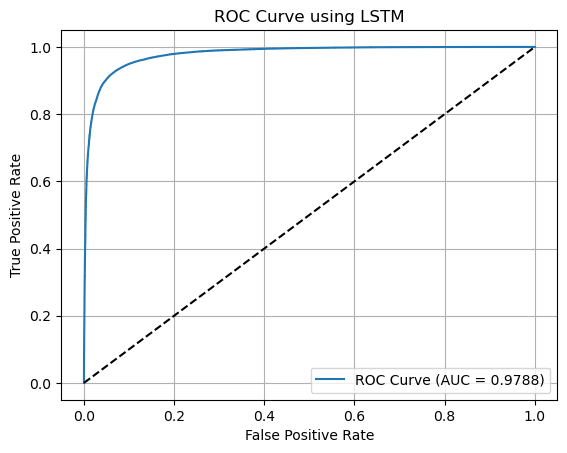

In [174]:
fpr2, tpr2, _ = roc_curve(y_test, pre_y_test2)
auc_score2 = roc_auc_score(y_test, pre_y_test2)

plt.figure()
plt.plot(fpr2, tpr2, label=f'ROC Curve (AUC = {auc_score2:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve using LSTM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## GLoVe+TextCNN

The second model is the GLoVe+TextCNN model. We still use the GLoVe pre-trained model as word embedding model. However, now we use TextCNN model as the classifier. 'filter_sizes' is a list that contains the sizes of the convolution kernels. 'num_filters' is the number of kernels for each size. We use dropout to control overfitting. During the convolution process, we choose ReLU as the activation function and use max pooling. The output of CNN will then go to a linear projection and a sigmoid activation. In the end, we will get results between 0 and 1.

Here, we choose the filter sizes to be 3,4,5, each size with 200 filters. We apply dropout on pooled convolution outputs with rate=0.5 to eliminate overfitting.

In [57]:
class TextCNN(nn.Module):
    def __init__(self, embedding_matrix, num_filters=200, filter_sizes=(3,4,5), dropout=0.5):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_matrix.size(1),
                      out_channels=num_filters,
                      kernel_size=fs)
            for fs in filter_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        conv_outs = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [torch.max(co, dim=2)[0] for co in conv_outs]

        concat = torch.cat(pooled, dim=1)
        dropped = self.dropout(concat)
        return self.sigmoid(self.fc(dropped))

The optimizer and loss criterion is same as LSTM.

In [145]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = TextCNN(embedding_matrix,num_filters=200, filter_sizes=(3,4,5), dropout=0.5).to(device)
optimizer = optim.Adam(model3.parameters(), lr=1e-4)
criterion = nn.BCELoss()

In [147]:
model3 = training(model3,train_loader,val_loader,optimizer,criterion,max_epoch=10,max_patience=1)

Epoch 1: 100%|██████████| 3125/3125 [01:01<00:00, 50.48it/s]


Epoch 1 Avg Train Loss: 0.3279 | Val Loss: 0.2507


Epoch 2: 100%|██████████| 3125/3125 [01:01<00:00, 50.45it/s]


Epoch 2 Avg Train Loss: 0.2402 | Val Loss: 0.2248


Epoch 3: 100%|██████████| 3125/3125 [01:01<00:00, 50.43it/s]


Epoch 3 Avg Train Loss: 0.2137 | Val Loss: 0.2128


Epoch 4: 100%|██████████| 3125/3125 [01:01<00:00, 50.43it/s]


Epoch 4 Avg Train Loss: 0.1956 | Val Loss: 0.2076


Epoch 5: 100%|██████████| 3125/3125 [01:01<00:00, 50.43it/s]


Epoch 5 Avg Train Loss: 0.1812 | Val Loss: 0.2052


Epoch 6: 100%|██████████| 3125/3125 [01:01<00:00, 50.42it/s]


Epoch 6 Avg Train Loss: 0.1685 | Val Loss: 0.2052
Early stop at Epoch 6


In [148]:
pre_y_val3 = predict(model3,val_loader)
print(classification_report(y_val,pre_y_val3>0.5))
print(accuracy_score(y_val,pre_y_val3>0.5))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92    100495
           1       0.92      0.92      0.92     99505

    accuracy                           0.92    200000
   macro avg       0.92      0.92      0.92    200000
weighted avg       0.92      0.92      0.92    200000

0.919705


In [149]:
confusion_matrix(y_val,pre_y_val3>0.5)

array([[92032,  8463],
       [ 7596, 91909]], dtype=int64)

In [150]:
pre_y_test3 = predict(model3,test_loader)
print(classification_report(y_test,pre_y_test3>0.5))
print(accuracy_score(y_test,pre_y_test3>0.5))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     50299
           1       0.92      0.92      0.92     49701

    accuracy                           0.92    100000
   macro avg       0.92      0.92      0.92    100000
weighted avg       0.92      0.92      0.92    100000

0.91893


In [151]:
confusion_matrix(y_test,pre_y_test3>0.5)

array([[46069,  4230],
       [ 3877, 45824]], dtype=int64)

Draw the ROC curve and compute the AUC.

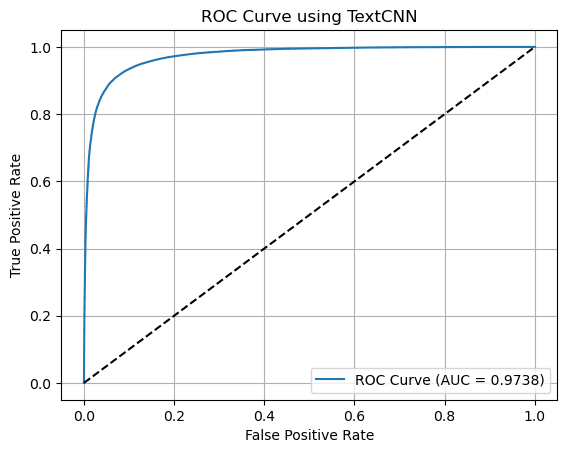

In [168]:
fpr3, tpr3, _ = roc_curve(y_test, pre_y_test3)
auc_score3 = roc_auc_score(y_test, pre_y_test3)

plt.figure()
plt.plot(fpr3, tpr3, label=f'ROC Curve (AUC = {auc_score3:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve using TextCNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Draw the three ROC curve together. To see the difference more clearly, we magnify a section of the figure.

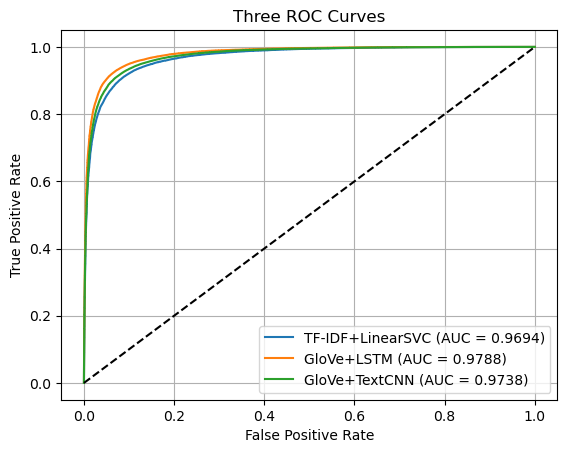

In [116]:
plt.figure()
plt.plot(fpr1, tpr1, label=f'TF-IDF+LinearSVC (AUC = {auc_score1:.4f})')
plt.plot(fpr2, tpr2, label=f'GloVe+LSTM (AUC = {auc_score2:.4f})')
plt.plot(fpr3, tpr3, label=f'GloVe+TextCNN (AUC = {auc_score3:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Three ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

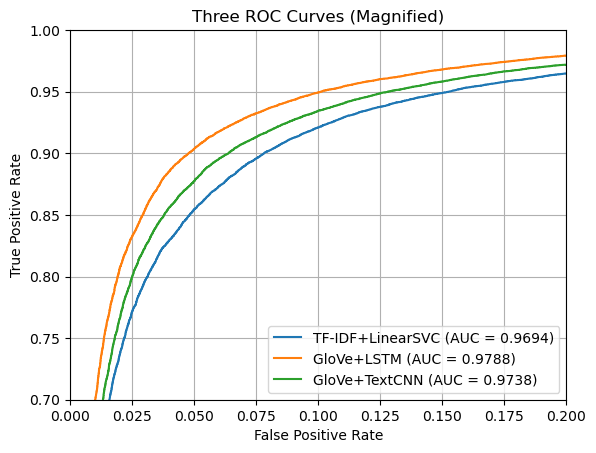

In [118]:
plt.figure()
plt.plot(fpr1, tpr1, label=f'TF-IDF+LinearSVC (AUC = {auc_score1:.4f})')
plt.plot(fpr2, tpr2, label=f'GloVe+LSTM (AUC = {auc_score2:.4f})')
plt.plot(fpr3, tpr3, label=f'GloVe+TextCNN (AUC = {auc_score3:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim(0,0.2)
plt.ylim(0.7,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Three ROC Curves (Magnified)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## BERT

Here we try to use BERT model. As a state-of-the-art (SOTA) model, BERT can significantly improve model performance across multiple natural language processing tasks without modifying its structure. To handle classification tasks, BERT model will add to each text (can be a sentence, paragraph, or article) a special token [CLS]. We can use the BERT output for this particular token as classification features

We use the module 'transformers' to load a BERT model 'bert-base-uncased' from Hugging Face. This model can give 768-dimensional outputs.

First, we use the tokenizer provided by BERT to tokenize the reviews. Every review will be padded or truncated to be of length 200. The tokenizer will output two things, input_ids (the vocabulary index for each word in a review) and attention_masks (whether the word is a padded one or not).

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(reviews):
    results = tokenizer(reviews, truncation=True, padding="max_length", max_length=200)
    return results['input_ids'], results['attention_mask']

X_train_input_ids, X_train_attention_masks = tokenize(list(X_train))
X_val_input_ids, X_val_attention_masks = tokenize(list(X_val))
X_test_input_ids, X_test_attention_masks = tokenize(list(X_test))

torch Dataset and DataLoader for BERT.

In [22]:
class BERTDataset(Dataset):
    def __init__(self, input_ids,attention_masks,y):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.input_ids[idx],dtype=torch.long), torch.tensor(self.attention_masks[idx],dtype=torch.long),torch.tensor(self.y[idx],dtype=torch.float)

train_dataset = BERTDataset(X_train_input_ids, X_train_attention_masks,y_train)
val_dataset = BERTDataset(X_val_input_ids, X_val_attention_masks,y_val)
test_dataset = BERTDataset(X_test_input_ids, X_test_attention_masks,y_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)


Our BERT model. A tokenized review will be put into the BERT model and we get the feature vector for [CLS]. Then we input the vector to a linear function and a sigmoid fucntion, and finally obtain a probability.

We use a rate=0.3 dropout.

In [29]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', dropout_rate=0.3):
        super().__init__()
        
        self.bert = BertModel.from_pretrained(bert_model_name)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(self.bert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        pooler_output = outputs.pooler_output  
        x = self.dropout(pooler_output)
        return self.sigmoid(self.linear(x)) 

     

The function below can conduct training process for BERT only. 'max_epoch' controls the epoch of the training process. To avoid overfitting, we also apply early stop. That is, whenever there exists a validation loss increasing, we will stop at that epoch.

In [31]:
def BERTtraining(model,train_loader,val_loader,optimizer,criterion,max_epoch=10,max_patience=1):
    if max_patience!=0:
      patience = 0
      min_val_loss = float('inf')
    for epoch in range(max_epoch):
        model.train()
        total_loss = 0
        for input_ids, attention_masks,y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids, attention_masks,y = input_ids.to(device), attention_masks.to(device), y.unsqueeze(1).to(device)
            optimizer.zero_grad()
            preds = model(input_ids,attention_masks)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for input_ids, attention_masks,y in tqdm(val_loader, desc=f"Epoch {epoch+1}"):
                input_ids, attention_masks,y = input_ids.to(device), attention_masks.to(device), y.unsqueeze(1).to(device)
                preds = model(input_ids,attention_masks)
                loss = criterion(preds, y)
                val_loss += loss.item()
                
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        if min_val_loss>avg_val_loss:
          min_val_loss = avg_val_loss
          patience = 0
        else:
          patience += 1
        print(f"Epoch {epoch+1} Avg Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        if patience == max_patience:
          print(f'Early stop at Epoch {epoch+1}')
          break
    return model

The optimizer and loss criterion is same as LSTM.

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4 = BERTClassifier(dropout_rate = 0.3).to(device)
optimizer = optim.Adam(model4.parameters(), lr=1e-4)
criterion = nn.BCELoss()

In [35]:
model4 = BERTtraining(model4,train_loader,val_loader,optimizer,criterion,max_epoch=10,max_patience=1)

Epoch 1: 100%|██████████| 1563/1563 [03:37<00:00,  7.17it/s]


Epoch 1 Avg Train Loss: 0.1529 | Val Loss: 0.1298


Epoch 2: 100%|██████████| 1563/1563 [03:41<00:00,  7.07it/s]


Epoch 2 Avg Train Loss: 0.1207 | Val Loss: 0.1290


Epoch 3: 100%|██████████| 1563/1563 [03:34<00:00,  7.30it/s]

Epoch 3 Avg Train Loss: 0.1045 | Val Loss: 0.1391
Early stop at Epoch 3


The function below can return the BERT predict probability as numpy array.

In [37]:
def BERTpredict(model,dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    outputs = []
    with torch.no_grad():
        for input_ids,attention_masks,_ in dataloader:
            input_ids,attention_masks = input_ids.to(device),attention_masks.to(device)
            pre = model(input_ids,attention_masks).squeeze()
            outputs.append(pre)
    outputs = torch.cat(outputs,dim=0)
    return outputs.detach().cpu().numpy()

In [39]:
pre_y_val4 = BERTpredict(model4,val_loader)
print(classification_report(y_val,pre_y_val4>0.5))
print(accuracy_score(y_val,pre_y_val4>0.5))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95    100495
           1       0.96      0.94      0.95     99505

    accuracy                           0.95    200000
   macro avg       0.95      0.95      0.95    200000
weighted avg       0.95      0.95      0.95    200000

0.951095


In [40]:
confusion_matrix(y_val,pre_y_val4>0.5)

array([[96231,  4264],
       [ 5517, 93988]], dtype=int64)

In [41]:
pre_y_test4 = BERTpredict(model4,test_loader)
print(classification_report(y_test,pre_y_test4>0.5))
print(accuracy_score(y_test,pre_y_test4>0.5))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     50299
           1       0.96      0.94      0.95     49701

    accuracy                           0.95    100000
   macro avg       0.95      0.95      0.95    100000
weighted avg       0.95      0.95      0.95    100000

0.95071


In [42]:
confusion_matrix(y_test,pre_y_test4>0.5)

array([[48111,  2188],
       [ 2741, 46960]], dtype=int64)

ROC curve and AUC.

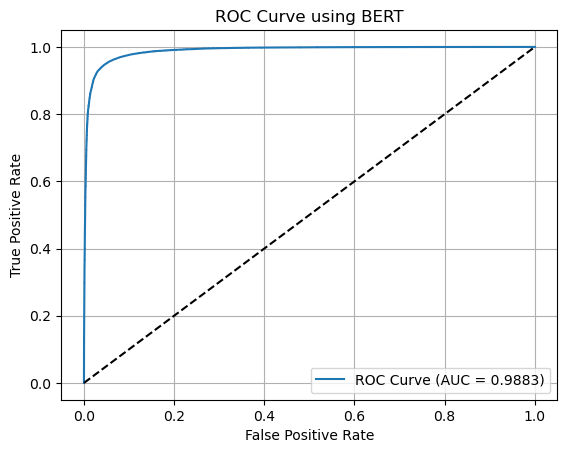

In [49]:
fpr4, tpr4, _ = roc_curve(y_test, pre_y_test4)
auc_score4 = roc_auc_score(y_test, pre_y_test4)

plt.figure()
plt.plot(fpr4, tpr4, label=f'ROC Curve (AUC = {auc_score4:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve using BERT')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

ROC curves and AUC values for all the four models.

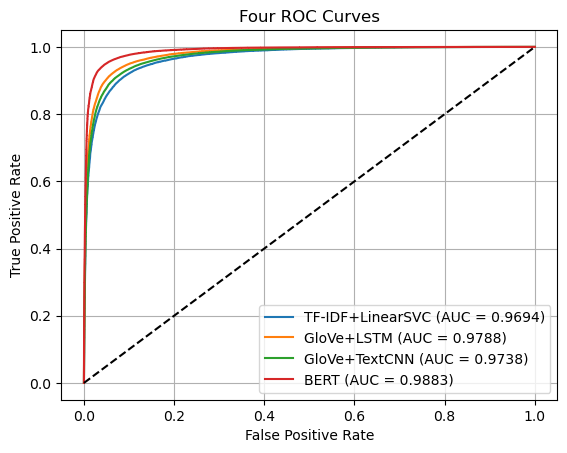

In [120]:
plt.figure()
plt.plot(fpr1, tpr1, label=f'TF-IDF+LinearSVC (AUC = {auc_score1:.4f})')
plt.plot(fpr2, tpr2, label=f'GloVe+LSTM (AUC = {auc_score2:.4f})')
plt.plot(fpr3, tpr3, label=f'GloVe+TextCNN (AUC = {auc_score3:.4f})')
plt.plot(fpr4, tpr4, label=f'BERT (AUC = {auc_score4:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Four ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

To see the difference more clearly, we magnify a section of the figure.

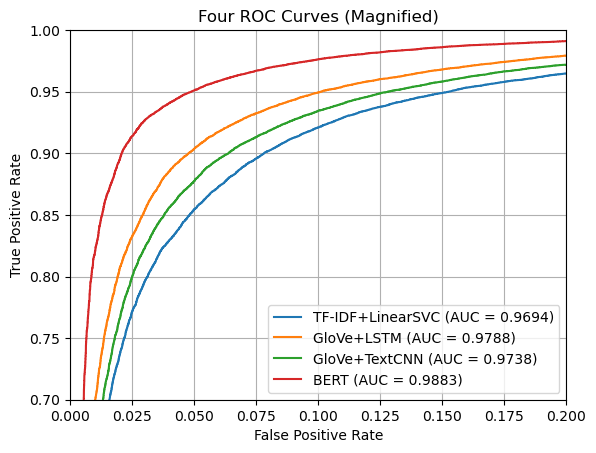

In [122]:
plt.figure()
plt.plot(fpr1, tpr1, label=f'TF-IDF+LinearSVC (AUC = {auc_score1:.4f})')
plt.plot(fpr2, tpr2, label=f'GloVe+LSTM (AUC = {auc_score2:.4f})')
plt.plot(fpr3, tpr3, label=f'GloVe+TextCNN (AUC = {auc_score3:.4f})')
plt.plot(fpr4, tpr4, label=f'BERT (AUC = {auc_score4:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim(0,0.2)
plt.ylim(0.7,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Four ROC Curves (Magnified)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()